In [1]:
import geopandas as gpd
import pandas as pd

# Load the hotel data
hotels_df = pd.read_excel('Classified Hotels( 1-5 Star).xlsx')
hotels_df['Grade'] = hotels_df['Grade'].map({'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR': 4, 'FIVE': 5})

# Load the shapefile
shapefile_gdf = gpd.read_file('Shape File\lka_admbnda_adm1_slsd_20220816.shp')


In [2]:
# Convert the hotels DataFrame to a GeoDataFrame
hotels_gdf = gpd.GeoDataFrame(
    hotels_df,
    geometry=gpd.points_from_xy(hotels_df.Logitiute, hotels_df.Latitude)
)

# Set the CRS for the hotels GeoDataFrame to match the shapefile
hotels_gdf.crs = shapefile_gdf.crs


In [11]:
import geopandas as gpd
import pandas as pd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN
import numpy as np

hotels_gdf['longitude'] = hotels_gdf.geometry.x
hotels_gdf['latitude'] = hotels_gdf.geometry.y

# Define the dependent variable (y) and independent variables (X)
y = hotels_gdf['Grade'].values.reshape((-1, 1))
X = hotels_gdf[['Rooms']].values  # Replace 'Rooms' with the correct column name

# Coordinates for GWR
u = hotels_gdf['longitude'].values.reshape((-1, 1))
v = hotels_gdf['latitude'].values.reshape((-1, 1))
coords = np.hstack([u, v])

# Select bandwidth for GWR; this is an important step to determine the spatial scale of analysis
bw = Sel_BW(coords, y, X).search()
gwr_model = GWR(coords, y, X, bw)

# Fit the GWR model
gwr_results = gwr_model.fit()

# Print the summary of GWR results
print(gwr_results.summary())


Model type                                                         Gaussian
Number of observations:                                                 141
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            184.684
Log-likelihood:                                                    -219.097
AIC:                                                                442.195
AICc:                                                               444.370
BIC:                                                               -503.194
R2:                                                                   0.321
Adj. R2:                                                              0.316

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

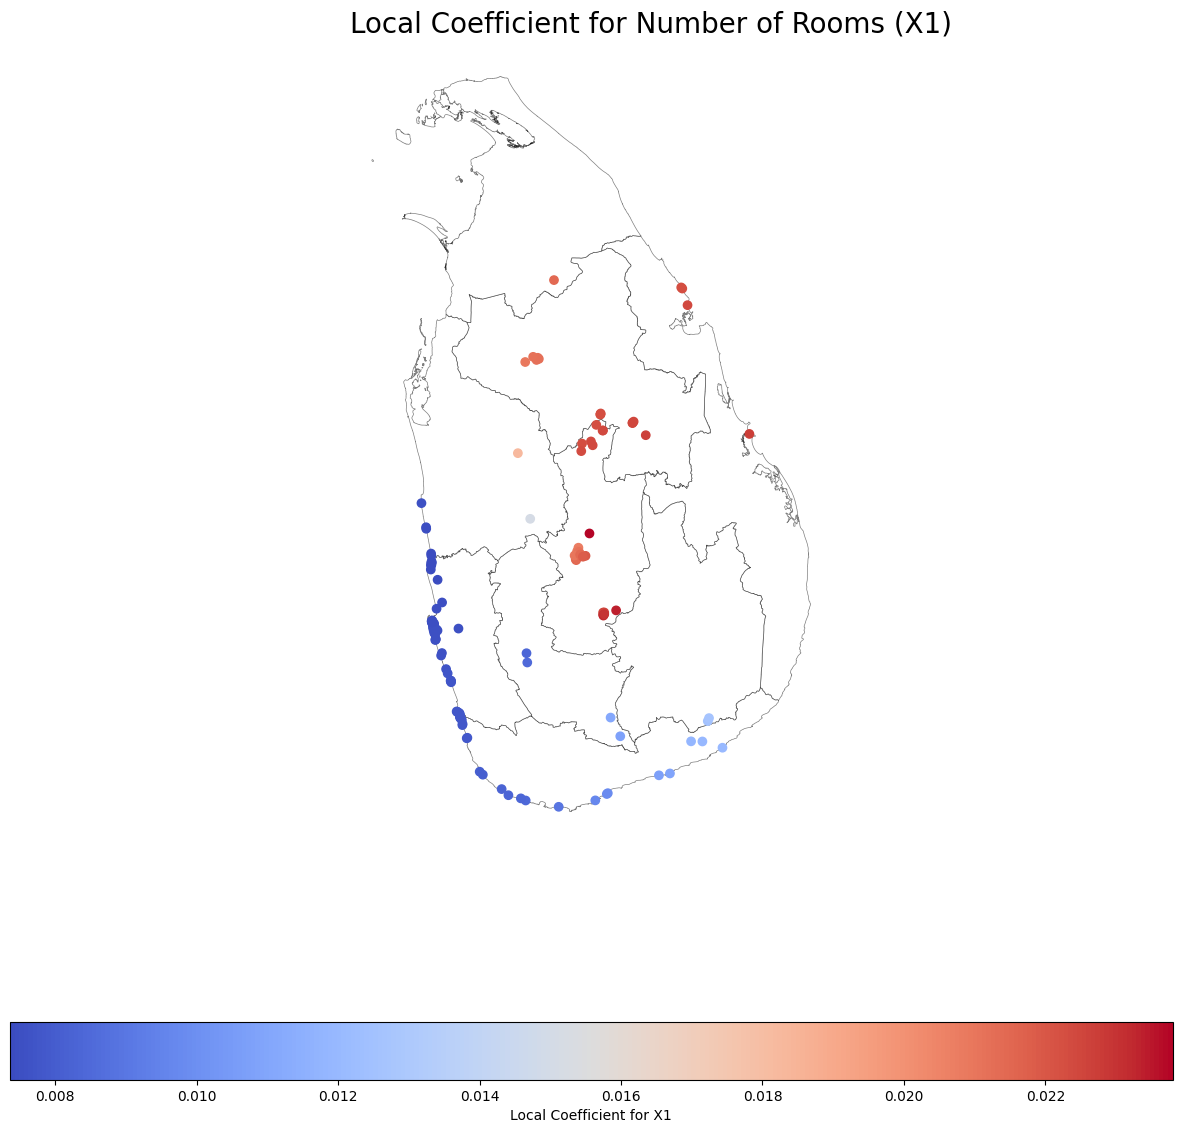

In [15]:
import matplotlib.pyplot as plt

hotels_gdf['local_coefficient_X1'] = gwr_results.params[:, 1] 

# Set up the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the base layer from shapefile
shapefile_gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5, alpha=0.5)

# Overlay the hotels with local coefficients
hotels_gdf.plot(column='local_coefficient_X1', ax=ax, legend=True,
                cmap='coolwarm', legend_kwds={'label': "Local Coefficient for X1",
                                               'orientation': "horizontal"})

ax.set_title('Local Coefficient for Number of Rooms (X1)', fontdict={'fontsize': 20}, loc='left')
ax.set_axis_off()

# Show the map
plt.show()
